In [1]:
import os
os.chdir('..\\..\\src\\models')

In [2]:
import simulate_pandemic 
import numpy as np
import pandas as pd
import plotly.express as px
from tqdm import tqdm
from disease_states import state_to_color
from pyproj import Transformer


import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"  ##offline plot
mapbox_access_token = 'pk.eyJ1IjoieWFtYmFuaXMiLCJhIjoiY2thbzFza2t6MXdkNTJ6cWg3emQxMjhmeCJ9.FJqkTcY28Pvhjbu-1XquMg'

Loading Graph... Done!


In [3]:
from policies import policies_restrictions

policy_names = list(policies_restrictions.keys())

In [4]:
list(policy_names)

['Lockdown',
 'Hard Quarantine',
 'Medium Quarantine',
 'Light Quarantine',
 'Social Distancing',
 'Unrestricted',
 'No_Policy']

In [5]:
simulations = {}
for p in policy_names:
    simulations[p] = simulate_pandemic.main(p)

  1%|▍                                                                                 | 3/499 [00:00<00:23, 21.03it/s]

{'work': 1, 'school': 1, 'home': 0, 'neighbor': 1}


  0%|▎                                                                                 | 2/499 [00:00<00:25, 19.28it/s]

{'work': 0.8, 'school': 1, 'home': 0, 'neighbor': 0.6}


  0%|▎                                                                                 | 2/499 [00:00<00:25, 19.85it/s]

{'work': 0.6, 'school': 1, 'home': 0, 'neighbor': 0.4}


  0%|▎                                                                                 | 2/499 [00:00<00:28, 17.75it/s]

{'work': 0.4, 'school': 1, 'home': 0, 'neighbor': 0.2}


  0%|▎                                                                                 | 2/499 [00:00<00:26, 18.91it/s]

{'work': 0.2, 'school': 0.2, 'home': 0, 'neighbor': 0.2}


  0%|▎                                                                                 | 2/499 [00:00<00:34, 14.42it/s]

{'work': 0, 'school': 0, 'home': 0, 'neighbor': 0}


  0%|▎                                                                                 | 2/499 [00:00<00:30, 16.30it/s]

{'work': 0, 'school': 0, 'home': 0, 'neighbor': 0}


100%|████████████████████████████████████████████████████████████████████████████████| 499/499 [01:10<00:00,  7.04it/s]


In [6]:
transformer = Transformer.from_crs('epsg:22523', 'epsg:4289')

def re_project(x,y):
    return transformer.transform(x,y)

def simulation_data_to_dataframe(data):
    df = pd.DataFrame(np.array(data))

    dfs = []
    for col in df.columns:
        size = len(df)
        p_id = size*[col+1]

        home_x, home_y = simulate_pandemic.G.nodes[col+1]['home_x'], simulate_pandemic.G.nodes[col+1]['home_y']
        home_x, home_y = re_project(home_x, home_y)
        home_x, home_y = home_x + np.random.normal(loc=0,scale=.001), home_y + np.random.normal(loc=0,scale=.001)
        home_x, home_y = size*[home_x] , size*[home_y]
        tmp = np.transpose([df[col], p_id, list(range(0, len(df[col]))), home_x, home_y])

        dfs.append(tmp)
        
    df_ts = pd.DataFrame(np.concatenate(dfs), columns = ['status', 'id', 'day', 'home_x', 'home_y'])
    fill = pd.DataFrame([['red', -1, 0, None, None], ['purple', -1, 0, None, None], 
                         ['orange', -1, 0, None, None], ['gray', -1, 0, None, None]],
                        columns = ['status', 'id', 'day', 'home_x', 'home_y'])

    df_ts.status = df_ts.status.apply(lambda x: state_to_color[x])
    df_ts = pd.concat([df_ts, fill]).reset_index(drop=True)
    
    return df_ts

In [7]:
dataframes = {}

for k,v in tqdm(simulations.items()):
    dataframes[k] = simulation_data_to_dataframe(v)


100%|██████████████████████████████████████████████████████████████████████████| 55492/55492 [00:20<00:00, 2732.14it/s]


In [8]:
def plot_map_animation(dfs_dict, sim_name, max_day=300, pop_size = 1000, save=True, plot=False):
    df_full = dfs_dict[sim_name]
    
    sample_ids = np.random.choice(df_full.id, replace=False, size = pop_size)
    sample_ids = np.concatenate([sample_ids, [-1]])


    df_plot = df_full[(df_full.id.isin(sample_ids)) & (df_full.day <= max_day)]

    max_day = int(df_plot.day.max())

    data = [go.Scattermapbox(
                   lat=df_plot[df_plot.day == 0]['home_x'],
                   lon=df_plot[df_plot.day == 0]['home_y'],
                   mode='markers',
                   marker=dict(size=5, color=df_plot[df_plot.day == 0]['status'])
                )
            ]

    layout = go.Layout(width=800,
        autosize=True,
        hovermode='closest',
        mapbox=dict(accesstoken=mapbox_access_token,
                    bearing=0,
                    center=dict(lat=-23.5505,
                                lon=-46.6333),
                    pitch=0,
                    zoom=10,
                    style='light'
                    )
                )

    frames = [dict(data= [dict(type='scattermapbox',
                               lat=df_plot[df_plot.day == day]['home_x'],
                               lon=df_plot[df_plot.day == day]['home_y'], mode='markers',
                               marker=dict(size=5, color=df_plot[df_plot.day == day]['status']))],
                   traces= [0], 
                   name='day {}'.format(day)       
                  )for day  in  range(1, max_day)] 

    sliders = [dict(steps= [dict(method= 'animate',
                               args= [[ 'day {}'.format(day) ],
                                      dict(mode= 'immediate',
                                      frame= dict( duration=100, redraw= True ),
                                               transition=dict( duration= 0)
                                              )
                                        ],
                                label='{:d}'.format(day)
                                 ) for day in range(1, max_day)], 
                    transition= dict(duration= 0 ),
                    x=0,#slider starting position  
                    y=0, 
                    currentvalue=dict(font=dict(size=12), 
                                      prefix='Point: ', 
                                      visible=True, 
                                      xanchor= 'center'),  
                    len=1.0)
               ]
    layout.update(updatemenus=[dict(type='buttons', showactive=False,
                                    y=0,
                                    x=1.05,
                                    xanchor='right',
                                    yanchor='top',
                                    pad=dict(t=0, r=10),
                                    buttons=[dict(label='Play',
                                                  method='animate',
                                                  args=[None, 
                                                        dict(frame=dict(duration=100, 
                                                                        redraw=True),
                                                             transition=dict(duration=0),
                                                             fromcurrent=True,
                                                             mode='immediate'
                                                            )
                                                       ]
                                                 )
                                            ]
                                   )
                              ],
                 #sliders=sliders,
                 title = sim_name);

    fig=go.Figure(data=data, layout=layout, frames=frames)
    if plot: fig.show()
    
    if save: fig.write_html(f"{sim_name}.html")


In [9]:
for k in dataframes.keys():
    print(k)
    plot_map_animation(dataframes, k, max_day=300, pop_size = 1000)

Lockdown
Hard Quarantine
Medium Quarantine
Light Quarantine
Social Distancing
Unrestricted
No_Policy


In [135]:
name = 'Medium Quarantine'
tmp = dataframes[name][['status', 'day']].groupby(by=['day', 'status']).size().reset_index()
tmp = tmp.rename(columns={0: 'total'})
hospitalized = tmp[tmp['status'] == 'purple'][['day', 'total']].copy()

hospitalized = hospitalized.astype(int)
end_date = hospitalized.day.max()
total_beds = 0.0025
range_days = range(0, end_date+1)
missing_days = [x for x in range_days if x not in  hospitalized.day.to_list()]
missing_data = pd.DataFrame([[x, 0] for x in missing_days], columns=['day', 'total'])

hospitalized = pd.concat([hospitalized, missing_data])
hospitalized = hospitalized.sort_values(by='day')
hospitalized['total'] = (hospitalized['total'] / 55492)

max_range_value_y = max(total_beds, hospitalized.total.max())*1.1

In [156]:
def hospital_capacity_animation(hospitalized, name, range_days, end_date,
                                max_range_value_y, 
                                total_beds= 0.0025, save=True):
                                
    fig = go.Figure(
        data=[go.Scatter(x=list(range_days), 
                         y=len(range_days)*[total_beds],
                         mode='lines',
                         name='frame',
                         line=dict(color="red", width=2)),       
             go.Scatter(x=list(range_days), 
                         y=len(range_days)*[total_beds],
                         mode='lines',
                         name='Total Hospital Beds',
                         line=dict(color="red", width=2)),
             ],
        layout=go.Layout(
            xaxis=dict(range=[0,end_date], autorange=False),
            yaxis=dict(range=[0,max_range_value_y], autorange=False),
            title=f"{name}",
            updatemenus=[dict(
                type="buttons",
                buttons=[dict(label="Play",
                              method="animate",
                              args=[None, {"frame": {"redraw": False},}])])]
        ),
        frames=[go.Frame(
            data=[go.Scatter(
                x=hospitalized[hospitalized.day <= day]['day'],
                y=hospitalized[hospitalized.day <= day]['total'],
                mode="lines",
                name = 'Hospitalized',
                line=dict(color="purple", width=2))],
            layout=go.Layout(title=f'Hospitalized at Day: {day}')
        ) for day  in  range(1, int(end_date))]
    )

    fig.show()
    if save: fig.write_html(f"{name}.html")

        
def make_hospital_animation(name, dataframes):
    print(1)
    tmp = dataframes[name][['status', 'day']].groupby(by=['day', 'status']).size().reset_index()
    tmp = tmp.rename(columns={0: 'total'})
    hospitalized = tmp[tmp['status'] == 'purple'][['day', 'total']].copy()
    print(2)
    hospitalized = hospitalized.astype(int)
    end_date = hospitalized.day.max()
    total_beds = 0.0025
    range_days = range(0, end_date+1)
    missing_days = [x for x in range_days if x not in  hospitalized.day.to_list()]
    missing_data = pd.DataFrame([[x, 0] for x in missing_days], columns=['day', 'total'])
    print(3)
    hospitalized = pd.concat([hospitalized, missing_data])
    hospitalized = hospitalized.sort_values(by='day')
    hospitalized['total'] = (hospitalized['total'] / 55492)
    plt.plot(range_days, hospitalized['total'])
    max_range_value_y = max(total_beds, hospitalized.total.max())*1.1

    print(4)
    hospital_capacity_animation(hospitalized, name, range_days, 
                                max_range_value_y, 
                                total_beds, save=True)

1
2
3
4


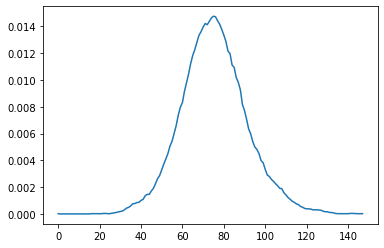

In [157]:
make_hospital_animation('Unrestricted',  dataframes)

In [154]:
import matplotlib.pyplot as plt